In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import xgboost as xg
from sklearn.metrics import mean_squared_error
from collections import Counter
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from scipy.stats import describe
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set theme of seaborn 
sns.set()

## Store Train Data, Dev and Test Data into dataframes


In [ ]:
#Train data
train_df = pd.read_csv("gdrive/My Drive/dataset/train.csv", dtype=str)
#Validation data
dev_df = pd.read_csv("gdrive/My Drive/dataset/dev.csv", dtype=str)
#Test data
test_df = pd.read_csv("gdrive/My Drive/dataset/truth_task_1.csv", dtype=str)
test_df.head()

,id,original,edit,grades,meanGrade
0,36,The Latest : Election tally shows <Austria/> t...,Cars,31110,1.2
1,2157,House Intel <Republicans/> Have Cleared Trump ...,onions,11000,0.4
2,9385,Christmas Is Canceled : Nazareth ’s Muslim <Ma...,grump,11111,1.0
3,14434,White House says Trump 's legal <team/> suppor...,bozos,32210,1.6
4,9462,Election <analysts/> move Ryan seat toward Dem...,movers,11000,0.4


## Function to RMSE Evaluation Criteria

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Competion Baseline is to atleast predict each value as avg. of all meanGrades in training data, which is done in the following cell

In [ ]:
y_train = train_df["meanGrade"].astype(float)
y_dev = dev_df["meanGrade"].astype(float)

In [ ]:
y_train

0       0.2
1       1.6
2       1.0
3       0.4
4       0.0
       ... 
9647    0.0
9648    0.4
9649    0.6
9650    1.4
9651    0.4
Name: meanGrade, Length: 9652, dtype: float64

In [ ]:
y_dev

0       1.0
1       0.8
2       0.6
3       1.6
4       0.4
       ... 
2414    0.2
2415    3.0
2416    1.4
2417    1.4
2418    0.6
Name: meanGrade, Length: 2419, dtype: float64

In [ ]:
y_test = test_df["meanGrade"].astype(float)
y_test

0       1.2
1       0.4
2       1.0
3       1.6
4       0.4
       ... 
3019    1.8
3020    0.6
3021    0.4
3022    0.0
3023    0.8
Name: meanGrade, Length: 3024, dtype: float64

In [ ]:
y_train_int = y_train.astype(float) * 10
y_train_int = y_train_int.astype(int)

In [ ]:
meanGrade = np.mean(y_train)
meanGrade

0.9355712114932938

Now we are finding RMSE for this baseline model

In [ ]:
[meanGrade] * len(y_test)

[0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114932938,
 0.9355712114

In [ ]:
baseline_rmse = rmse(y_test,[meanGrade] * len(y_test))
baseline_rmse

0.5747096554442188

## Data Preprocessing

In [ ]:
train_df.shape

(9652, 5)

In [ ]:
dev_df.shape

(2419, 5)

In [ ]:
test_df.shape

(3024, 5)

**We are first removing < and /> from original headline to create a new headline using the edited word given in the dataset**

In [ ]:
train_df['original']

0       France is ‘ hunting down its citizens who join...
1       Pentagon claims 2,000 % increase in Russian tr...
2       Iceland PM Calls Snap Vote as Pedophile Furor ...
3       In an apparent first , Iran and Israel <engage...
4       Trump was told weeks ago that Flynn misled <Vi...
                              ...                        
9647    State officials blast ' unprecedented ' DHS <m...
9648    Protesters Rally for <Refugees/> Detained at J...
9649    Cruise line Carnival Corp. joins the fight aga...
9650    Columbia police hunt woman seen with <gun/> ne...
9651    Here 's What 's In The House-Approved Health <...
Name: original, Length: 9652, dtype: object

In [ ]:
train_df['edit']

0              twins
1            bowling
2              party
3               slap
4             school
            ...     
9647            idea
9648    stewardesses
9649          raisin
9650            cake
9651            food
Name: edit, Length: 9652, dtype: object

In [ ]:
train_df["new"] = train_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
#Reference: https://stackoverflow.com/questions/14007545/python-regex-instantly-replace-groups
train_df["original"] = train_df["original"].str.replace(r"<(.+)/>", "\g<1>")

dev_df["new"] = dev_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
dev_df["original"] = dev_df["original"].str.replace(r"<(.+)/>", "\g<1>")

test_df["new"] = test_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
test_df["original"] = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")

In [ ]:
train_df['original']

0       France is ‘ hunting down its citizens who join...
1       Pentagon claims 2,000 % increase in Russian tr...
2       Iceland PM Calls Snap Vote as Pedophile Furor ...
3       In an apparent first , Iran and Israel engage ...
4       Trump was told weeks ago that Flynn misled Vic...
                              ...                        
9647    State officials blast ' unprecedented ' DHS mo...
9648    Protesters Rally for Refugees Detained at JFK ...
9649    Cruise line Carnival Corp. joins the fight aga...
9650    Columbia police hunt woman seen with gun near ...
9651    Here 's What 's In The House-Approved Health C...
Name: original, Length: 9652, dtype: object

In [ ]:
train_df['new']

0       France is ‘ hunting down its citizens who join...
1       Pentagon claims 2,000 % increase in Russian tr...
2       Iceland PM Calls Snap Vote as Pedophile Furor ...
3       In an apparent first , Iran and Israel slap ea...
4       Trump was told weeks ago that Flynn misled sch...
                              ...                        
9647    State officials blast ' unprecedented ' DHS id...
9648    Protesters Rally for stewardesses Detained at ...
9649    Cruise line Carnival Corp. joins the fight aga...
9650    Columbia police hunt woman seen with cake near...
9651    Here 's What 's In The House-Approved Health f...
Name: new, Length: 9652, dtype: object

In [ ]:
dev_df['original']

0       Thousands of gay and bisexual men convicted of...
1            Special prosecutor appointed to Trump Russia
2       Spanish police detain man and search Ripoll ad...
3       N.Y. Times reprimands reporter for sharing ' u...
4       Vladimir Putin Releases Video Simulation Of Ru...
                              ...                        
2414    Supreme Court Once Again Strikes Down Racial G...
2415    Trump Mocks Schumer ’s Tears ; Vows to ‘ Make ...
2416    US government memo on the danger of leaking to...
2417    Newt Gingrich : Join Me in Supporting Judge Ro...
2418       In Search of Donald Trump at His Boyhood Home 
Name: original, Length: 2419, dtype: object

In [ ]:
dev_df['new']

0       Thousands of gay and bisexual swans convicted ...
1                  Special chef appointed to Trump Russia
2       Spanish police detain man and search Ripoll ad...
3       N.Y. Times applauds reporter for sharing ' unf...
4       Vladimir Putin Releases Video Simulation Of Ru...
                              ...                        
2414    Supreme leaders Once Again Strikes Down Racial...
2415    Trump Mocks Schumer ’s Tears ; Vows to ‘ Make ...
2416    US government memo on the amusement of leaking...
2417    Newt Gingrich : Join Me in Supporting Judge Ro...
2418     In Search of Donald Trump at His Boyhood Castle 
Name: new, Length: 2419, dtype: object

In [ ]:
test_df['original']

0       The Latest : Election tally shows Austria turn...
1       House Intel Republicans Have Cleared Trump . S...
2       Christmas Is Canceled : Nazareth ’s Muslim May...
3       White House says Trump 's legal team supports ...
4       Election analysts move Ryan seat toward Dems a...
                              ...                        
3019    Sen. Bernie Sanders says he ’s “ sickened ” by...
3020    Trump Repeals Regulation Protecting Workers Fr...
3021    Spicer : We do n't regret repeating claim that...
3022    Gunshots Fired Outside Houses of Parliament in...
3023    Flynn has promised Special Counsel ' full coop...
Name: original, Length: 3024, dtype: object

In [ ]:
test_df['new']

0       The Latest : Election tally shows Cars turning...
1       House Intel onions Have Cleared Trump . So Are...
2       Christmas Is Canceled : Nazareth ’s Muslim gru...
3       White House says Trump 's legal bozos supports...
4       Election movers move Ryan seat toward Dems aft...
                              ...                        
3019    Sen. Bernie Sanders says he ’s “ sickened ” by...
3020    Trump Repeals Regulation Protecting Owners Fro...
3021    Spicer : We do n't regret repeating claim that...
3022      Gunshots Fired Outside Houses of dogs in London
3023    Flynn has promised Special Counsel ' full mont...
Name: new, Length: 3024, dtype: object

**Next, we will do pre-processing to removal of stop words, special characters. We will also do expansion of all the contractions present in text**

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
sent_0_original = train_df['original'].values[0]
print(sent_0_original)
sent_0_new = train_df['new'].values[0]
print(sent_0_new)
print("="*50)
sent_1000_original = train_df['original'].values[1000]
print(sent_1000_original)
sent_1000_new = train_df['new'].values[1000]
print(sent_1000_new)
print("="*50)

France is ‘ hunting down its citizens who joined Isis ’ without trial in Iraq
France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Mike Pence Told About Flynn Warning Two Weeks After Trump , White House
Mike Pence Told About Flynn odor Two Weeks After Trump , White House


In [ ]:
#Reference: https://stackoverflow.com/a/5843547/4084039
sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0_original)
print(sent_0)

France is hunting down its citizens who joined Isis without trial in Iraq


In [ ]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#Reference: https://stackoverflow.com/a/47091490/4084039

In [ ]:
def preprocess(df, column):
    
    preprocessed_sentences =[]
        for sentence in tqdm(df[column].values):
        sentence = decontracted(sentence)
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop_words)
        preprocessed_sentences.append(sentence.strip())
    return preprocessed_sentences

In [ ]:
print(train_df['original'].head())

0    France is ‘ hunting down its citizens who join...
1    Pentagon claims 2,000 % increase in Russian tr...
2    Iceland PM Calls Snap Vote as Pedophile Furor ...
3    In an apparent first , Iran and Israel engage ...
4    Trump was told weeks ago that Flynn misled Vic...
Name: original, dtype: object


In [ ]:
train_df['original']= preprocess(train_df,'original')
train_df['original'].head()

100%|██████████| 9652/9652 [00:00<00:00, 40600.72it/s]


0    france hunting citizens joined isis without tr...
1    pentagon claims increase russian trolls syria ...
2    iceland pm calls snap vote pedophile furor cra...
3         apparent first iran israel engage militarily
4     trump told weeks ago flynn misled vice president
Name: original, dtype: object

In [ ]:
train_df['new']= preprocess(train_df,'new')
train_df['new'].head()

100%|██████████| 9652/9652 [00:00<00:00, 40277.84it/s]


0    france hunting citizens joined twins without t...
1    pentagon claims increase russian trolls bowlin...
2    iceland pm calls snap vote pedophile furor cra...
3           apparent first iran israel slap militarily
4    trump told weeks ago flynn misled school presi...
Name: new, dtype: object

In [ ]:
dev_df['original']= preprocess(dev_df,'original')
dev_df['new']= preprocess(dev_df,'new')
dev_df['new'].head()

100%|██████████| 2419/2419 [00:00<00:00, 43518.07it/s]


0    thousands gay bisexual swans convicted long ab...
1                  special chef appointed trump russia
2    spanish police detain man search ripoll addres...
3    n times applauds reporter sharing unfounded ru...
4    vladimir putin releases video simulation russi...
Name: new, dtype: object

In [ ]:
test_df['original']= preprocess(test_df,'original')
test_df['new']= preprocess(test_df,'new')
test_df['new'].head()

100%|██████████| 3024/3024 [00:00<00:00, 44797.55it/s]


0       latest election tally shows cars turning right
1    house intel onions cleared trump russia invest...
2    christmas canceled nazareth muslim grump bans ...
3    white house says trump legal bozos supports se...
4    election movers move ryan seat toward dems ret...
Name: new, dtype: object

## Now we do featurization of textual Sentences into Numeric Vectors using Bag of Words method

In [ ]:
unigram = (1, 1)
bigram = (1, 2)
trigram = (1, 3)
n_gram = bigram

In [ ]:
bow_train = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
)
X_train_original = bow_train.fit_transform(train_df["original"])
train_vocab = bow_train.get_feature_names()
bow_dev = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
    vocabulary=train_vocab,
)

X_dev_original = bow_dev.fit_transform(dev_df["original"])
X_test_original = bow_dev.fit_transform(test_df["original"])

In [ ]:
bow_train = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
)
X_train_edited = bow_train.fit_transform(train_df["new"])

train_vocab = bow_train.get_feature_names()

bow_dev = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
    vocabulary=train_vocab, 
)

X_dev_edited = bow_dev.fit_transform(dev_df["new"])

X_test_edited = bow_dev.fit_transform(test_df["new"])



In [ ]:
X_train = hstack((X_train_original, X_train_edited))
X_dev = hstack((X_dev_original, X_dev_edited))
X_test = hstack((X_test_original, X_test_edited))


In [ ]:
X_train.shape

(9652, 50494)

In [ ]:
X_dev.shape

(2419, 50494)

In [ ]:
X_test.shape

(3024, 50494)

In [ ]:
def roundPred(predictions):
    final_predictions = []
    for val in predictions:
        val = int(val * 10)
        final_predictions.append(val / 10)
    return final_predictions

## Model Building

In [ ]:
model_results = {}
model_results["BASELINE"] = baseline_rmse

### a) Linear Regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
predictions = roundPred(lin_reg.predict(X_dev))

In [ ]:
lin_reg_rmse = rmse(y_dev, predictions)

In [ ]:
lin_reg_rmse

1.0482213916849554

In [ ]:
predictions = roundPred(lin_reg.predict(X_test))

In [ ]:
lin_reg_rmse = rmse(y_test, predictions)

In [ ]:
lin_reg_rmse

1.0158238765397023

In [ ]:
model_results["Linear Regression"] = lin_reg_rmse

### b) Random Forest Regressor

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=10, n_jobs=-1, verbose=1, random_state=42)
rf_reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
predictions = roundPred(rf_reg.predict(X_dev))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
rf_rmse = rmse(y_dev, predictions)

In [ ]:
rf_rmse

0.6216335545537807

In [ ]:
predictions = roundPred(rf_reg.predict(X_test))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
rf_rmse = rmse(y_test, predictions)
rf_rmse

0.599385156754458

In [ ]:
model_results["Random Forest"] = rf_rmse

We will now try to do some hyperparameter tuning on Random Forest

In [ ]:
results_rf_optimize = {}

In [ ]:
time_dict = {}

In [ ]:
for n in range(10, 201, 20):
    start = time.time()
    rf_reg = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    predictions = roundPred(rf_reg.predict(X_dev))
    rf_rmse = rmse(dev_df["meanGrade"], predictions)
    results_rf_optimize[n] = rf_rmse
    end = time.time()
    time_dict[n]= start-end
    print(f"N: {n} --> {rf_rmse:.5f}")

N: 10 --> 0.62139
N: 30 --> 0.60939
N: 50 --> 0.60754
N: 70 --> 0.60763
N: 90 --> 0.60536
N: 110 --> 0.60559
N: 130 --> 0.60594
N: 150 --> 0.60595
N: 170 --> 0.60608
N: 190 --> 0.60574


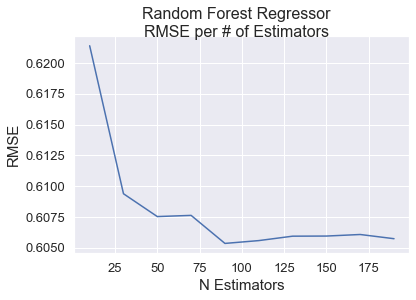

In [ ]:
results_df = (
    pd.DataFrame(results_rf_optimize.items(), columns=["n_estimators", "RMSE"])
    .sort_values("n_estimators")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="n_estimators", y="RMSE", data=results_df, color="b")
plt.suptitle("Random Forest Regressor\nRMSE per # of Estimators", fontsize=16)
ax.set_xlabel("N Estimators", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

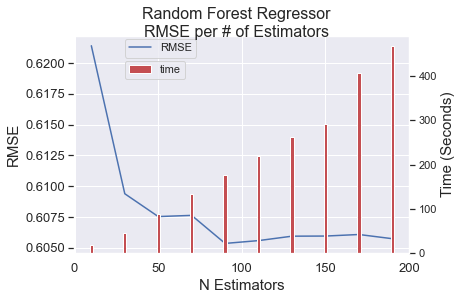

In [ ]:
time_df = (
    pd.DataFrame(time_dict.items(), columns=["n_estimators", "time"])
    .sort_values("time")
    .reset_index(drop=True)
)
time_df["time"] = time_df["time"].apply(lambda x: abs(x))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(results_df["n_estimators"], results_df["RMSE"], color='b', label="RMSE")
ax2 = ax1.twinx()
ln2 = ax2.bar(time_df["n_estimators"], time_df["time"], color='r', width = 2, label="time")
ax2.grid(False)
plt.suptitle("Random Forest Regressor\nRMSE per # of Estimators", fontsize=16)
ax1.set_xlabel("N Estimators", fontsize=15)
ax1.set_ylabel("RMSE", fontsize=15)
ax2.set_ylabel("Time (Seconds)", fontsize=15)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax1.legend(loc = (.15,.9), frameon = True)
ax2.legend( loc = (.15, .8), frameon = True)

In [ ]:
results_df.sort_values("RMSE").head(1)

,n_estimators,RMSE
4,90,0.605357


In [ ]:
model_results["Random Forest"] = results_df.sort_values("RMSE").head(1).iloc[0]["RMSE"]
model_results["Random Forest"]

0.6053570960389245

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=90, n_jobs=-1, verbose=1, random_state=42) #n_estimators=90 from above
rf_reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


RandomForestRegressor(n_estimators=90, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
predictions = roundPred(rf_reg.predict(X_test))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:    0.1s finished


In [ ]:
rf_rmse = rmse(y_test, predictions)
rf_rmse

0.5879634837309696

In [ ]:
model_results["Random Forest"] = rf_rmse

### c) Ada Boost Regressor

In [ ]:
ada_results_optimize = {}

In [ ]:
for n in range(10, 51, 10):
    ada_reg = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        n_estimators=n,
        random_state=42,
        loss="linear",
    )
    ada_reg.fit(X_train, y_train)
    predictions = roundPred(ada_reg.predict(X_dev))
    ada_rmse = rmse(dev_df["meanGrade"], predictions)
    ada_results_optimize[n] = ada_rmse
    print(f"N: {n} --> {ada_rmse:.5f}")

N: 10 --> 0.57443
N: 20 --> 0.58391
N: 30 --> 0.58391
N: 40 --> 0.58391
N: 50 --> 0.58391


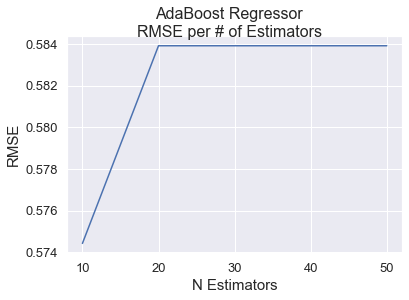

In [ ]:
ada_results_df = (
    pd.DataFrame(ada_results_optimize.items(), columns=["n_estimators", "RMSE"])
    .sort_values("n_estimators")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="n_estimators", y="RMSE", data=ada_results_df)
plt.suptitle("AdaBoost Regressor\nRMSE per # of Estimators", fontsize=16)
ax.set_xlabel("N Estimators", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

In [ ]:
ada_results_df.sort_values("RMSE").head(1)

,n_estimators,RMSE
0,10,0.574427


In [ ]:
model_results["Ada Boost"] = ada_results_df.sort_values("RMSE").head(1).iloc[0]["RMSE"]
model_results["Ada Boost"]

0.5744274788716537

In [ ]:
ada_reg = AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
        n_estimators=10, #best value we found above
        random_state=42,
        loss="linear",
    )
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                       random_state=42),
                  n_estimators=10, random_state=42)

In [ ]:
predictions = roundPred(ada_reg.predict(X_test))
ada_rmse = rmse(y_test, predictions)
ada_rmse

0.5684263062248841

In [ ]:
model_results["AdaBoost"] = ada_rmse

### d) Support Vector Machines

#### 1. Linear SVR

In [ ]:
lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train, y_train)

LinearSVR(random_state=42)

In [ ]:
predictions = roundPred(lin_svr.predict(X_dev))
lin_svr_rmse = rmse(y_dev, predictions)

In [ ]:
lin_svr_rmse

0.7152620740976094

In [ ]:
predictions = roundPred(lin_svr.predict(X_test))
lin_svr_rmse = rmse(y_test, predictions)

In [ ]:
lin_svr_rmse

0.7035083096872004

In [ ]:
model_results["Linear SVR"] = lin_svr_rmse

In [ ]:
for c in range(1, 21, 1):
    c = c / 10
    svr = LinearSVR(C=c)
    svr.fit(X_train, y_train)
    preds = roundPred(svr.predict(X_dev))

    RMSE = rmse(dev_df["meanGrade"], preds)
    print(c, RMSE)

0.1 0.598185211909324
0.2 0.6172891435381427
0.3 0.6338918941298838
0.4 0.647889058018902
0.5 0.6612714024619025
0.6 0.6748876470119253
0.7 0.6864814037189371
0.8 0.6977344783170224
0.9 0.7061180697306686
1.0 0.7154614430407018
1.1 0.7230882050582325
1.2 0.7307315389790576
1.3 0.737993324049387
1.4 0.7441712320790084
1.5 0.7488947347174196
1.6 0.7549013060067293
1.7 0.7600151213656365
1.8 0.7650515306591245
1.9 0.7701382061372454
2.0 0.7743484639444074


In [ ]:
for c in range(1, 10, 1):
    c = c / 100
    svr = LinearSVR(C=c)
    svr.fit(X_train, y_train)
    preds = roundPred(svr.predict(X_dev))

    RMSE = rmse(dev_df["meanGrade"], preds)
    print(c, RMSE)

0.01 0.5805871498844909
0.02 0.5816719781823455
0.03 0.585246473978139
0.04 0.5864918720650325
0.05 0.5898479705473488
0.06 0.591639421824476
0.07 0.5926586840948075
0.08 0.5950880655036166
0.09 0.5968741782166025


In [ ]:
lin_svr = LinearSVR(random_state=42, C=0.01)
lin_svr.fit(X_train, y_train)

LinearSVR(C=0.01, random_state=42)

In [ ]:
predictions = roundPred(lin_svr.predict(X_test))
lin_svr = rmse(y_test, predictions)
lin_svr

0.5744274812514902

#### 2. NuSVR

In [ ]:
nu_svr = NuSVR()
nu_svr.fit(X_train, y_train)

NuSVR()

In [ ]:
predictions = roundPred(nu_svr.predict(X_dev))
nu_svr_rmse = rmse(y_dev, predictions)

In [ ]:
nu_svr_rmse

0.5745030384735822

In [ ]:
predictions = roundPred(nu_svr.predict(X_test))
nu_svr_rmse = rmse(y_test, predictions)
nu_svr_rmse

0.5671683120378767

In [ ]:
model_results["NuSVR"] = nu_svr_rmse

#### 3. RBF-Kernel SVR

In [ ]:
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [ ]:
predictions = roundPred(svr.predict(X_dev))
svr_rmse = rmse(y_dev, predictions)

In [ ]:
svr_rmse

0.577270308158382

In [ ]:
predictions = roundPred(svr.predict(X_test))
svr_rmse = rmse(y_test, predictions)

In [ ]:
svr_rmse

0.5681586334856075

In [ ]:
model_results["SVR"] = svr_rmse

#### Tuning SVM Models

In [ ]:
for svm in [LinearSVR, NuSVR, SVR]:
    print(svm)
    svm = svm()
    svm.fit(X_train, y_train)
    preds = roundPred(svm.predict(X_dev))
    RMSE = rmse(y_dev, preds)
    print(RMSE, "\n")

<class 'sklearn.svm._classes.LinearSVR'>
0.7153921036231919 

<class 'sklearn.svm._classes.NuSVR'>
0.5745030384735822 

<class 'sklearn.svm._classes.SVR'>
0.577270308158382 



In [ ]:
svr_kernel = {}
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    svr = SVR(kernel=kernel)
    svr.fit(X_train, y_train)
    preds = roundPred(svr.predict(X_dev))
    
    RMSE = rmse(dev_df["meanGrade"], preds)
    svr_kernel[kernel] = RMSE
    print(f"{kernel}: {RMSE:.5f}")

linear: 0.68673
poly: 0.69136
rbf: 0.57727
sigmoid: 0.59184


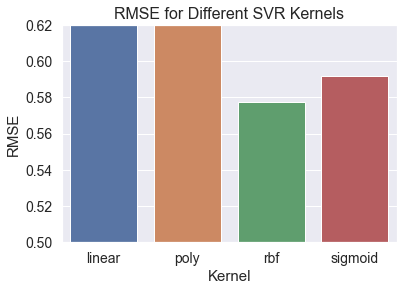

In [ ]:
ax = sns.barplot(x=list(svr_kernel.keys()), y=list(svr_kernel.values()))
plt.ylim(.5,.62);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Kernel', fontsize=15);
ax.set_ylabel('RMSE', fontsize=15);
ax.set_title("RMSE for Different SVR Kernels", fontsize=16);

**The best kernel is "RBF". Now we will tune the 'C' parameter.**

In [ ]:
svr_rbf_c_results = {}

In [ ]:
for c in range(2, 41, 2):
    c = c / 10
    svr = SVR(kernel="rbf",C=c)
    svr.fit(X_train, y_train)
    preds = roundPred(svr.predict(X_dev))

    RMSE = rmse(dev_df["meanGrade"], preds)
    svr_rbf_c_results[c] = RMSE
    print(c, RMSE)

0.2 0.5774099343857949
0.4 0.5763601200738779
0.6 0.5763457749068671
0.8 0.5760552084147786
1.0 0.577270308158382
1.2 0.5775208952552167
1.4 0.5774349919297578
1.6 0.5771342295989582
1.8 0.5763852232570561
2.0 0.5769730424298707
2.2 0.576528649049521
2.4 0.5764354263437572
2.6 0.5773419155701089
2.8 0.5771449738096283
3.0 0.5768978063385639
3.2 0.5766433639984848
3.4 0.5772345011213627
3.6 0.5779073022016514
3.8 0.5788400540608784
4.0 0.5791684820779639


In [ ]:
sorted(svr_rbf_c_results.items(), key=lambda x: x[1])[0]

(0.8, 0.5760552084147786)

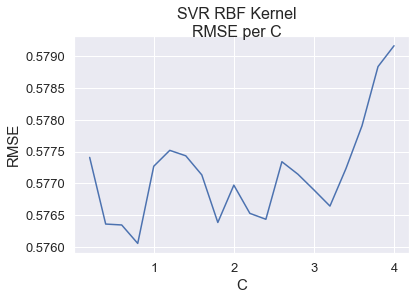

In [ ]:
svr_rbf_c_results_df = (
    pd.DataFrame(svr_rbf_c_results.items(), columns=["C", "RMSE"])
    .sort_values("C")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="C", y="RMSE", data=svr_rbf_c_results_df, color="b")
plt.suptitle("SVR RBF Kernel\nRMSE per C", fontsize=16)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

#### SVM Model with best hyperparameters:

In [ ]:
SVR_RBF = SVR(kernel="rbf", C=0.8)
SVR_RBF.fit(X_train, y_train)
predictions = roundPred(SVR_RBF.predict(X_dev))

SVR_RBF_RMSE = rmse(dev_df["meanGrade"], predictions)

In [ ]:
predictions = roundPred(SVR_RBF.predict(X_test))

SVR_RBF_RMSE = rmse(y_test, predictions)
print(f"SVR_RBF: {SVR_RBF_RMSE:.5f}")

SVR_RBF: 0.56848


In [ ]:
model_results["SVR_RBF"] = SVR_RBF_RMSE

| Parameter | Value   |
|-----------|---------|
| Model     | SVR     |
| Kernel    | rbf     |
| C         | 0.8   |
| Epsilon   | 0.1     |
| RMSE      | 0.56848 |

### e) XGBoost Model

In [ ]:
import xgboost as xgb

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

In [ ]:
predictions = roundPred(xgb_reg.predict(X_dev))
xgb_reg_rmse = rmse(y_dev, predictions)

In [ ]:
xgb_reg_rmse

0.5757860346243716

In [ ]:
predictions = roundPred(xgb_reg.predict(X_test))
xgb_reg_rmse = rmse(y_test, predictions)

In [ ]:
xgb_reg_rmse

0.5683652181159762

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_root_mean_squared_error',
                         n_iter=25,
                         verbose=1)


clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7999999999999999}

In [ ]:
xgb_reg = xgb.XGBRegressor(subsample= 0.6, n_estimators= 500, max_depth= 20, learning_rate= 0.01, colsample_bytree= 0.799, colsample_bylevel= 0.799)
xgb_reg.fit(X_train, y_train)

In [ ]:
predictions = roundPred(xgb_reg.predict(X_test))
xgb_reg_rmse = rmse(y_test, predictions)

In [ ]:
xgb_reg_rmse

0.5632688748695648

### f) Stacking Regressor Model

In [ ]:
from sklearn.ensemble import StackingRegressor

level0 = list()
level0.append(('rbf-svr',SVR(kernel="rbf", C=0.8)))
level0.append(('nu-svr', NuSVR()))
level0.append(('xgb', xgb.XGBRegressor(subsample= 0.6, n_estimators= 500, max_depth= 20, learning_rate= 0.01, colsample_bytree= 0.799, colsample_bylevel= 0.799)))
level1 = LinearRegression()
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, y_train)

In [ ]:
predictions = roundPred(model.predict(X_test))
stacking_reg_rmse = rmse(y_test, predictions)

In [ ]:
stacking_reg_rmse

0.5611661139158417

In [ ]:
def preds_to_csv(df, predictions, file_name="gdrive/My Drive/bow-output.csv"):
    final_df = pd.DataFrame(df["id"])
    final_df["pred"] = predictions
    final_df.to_csv(file_name, index=False)
    return f"Final Predictions saved to: {file_name}"

In [ ]:
preds_to_csv(test_df, predictions)

'Final Predictions saved to: gdrive/My Drive/bow-output.csv'

## Conclusion: 

**Stacking Regression Model is the best performing model with RMSE as 0.5611**

